In [1]:
import sys
sys.path.append('../')
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA as ARIMA_sm
from gtime.preprocessing import TimeSeriesPreparation
from gtime.time_series_models import ARIMA, AR
from sklearn.compose import make_column_selector
from gtime.feature_extraction import Shift
from sklearn.metrics import mean_squared_error
from scipy.stats import normaltest
from numpy.linalg import multi_dot
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from gtime.stat_tools.mle_estimate import _run_css, _run_mle
%matplotlib inline  
%load_ext Cython


## TIme series

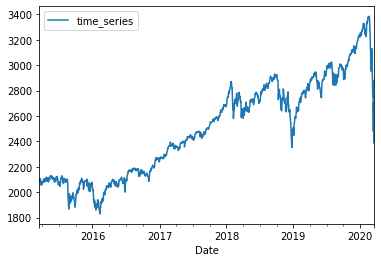

In [17]:
df_sp = pd.read_csv('https://storage.googleapis.com/l2f-open-models/giotto-time/examples/data/^GSPC.csv', parse_dates=['Date'])
df_close = df_sp.set_index('Date')['Close']
time_series_preparation = TimeSeriesPreparation()
df_real = time_series_preparation.transform(df_close)

df_real.plot();

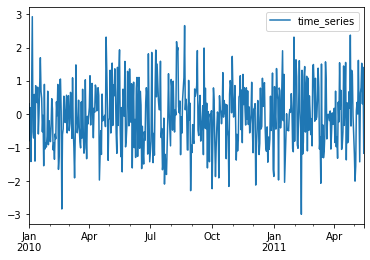

In [18]:
df_white = pd.DataFrame(np.random.standard_normal(500))
time_series_preparation = TimeSeriesPreparation(start='01-01-2010', freq='1D')
df_white = time_series_preparation.transform(df_white)

df_white.plot();

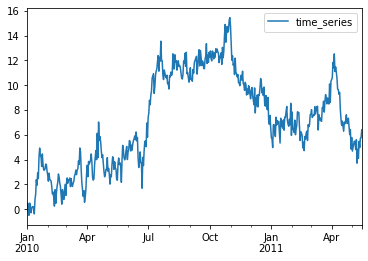

In [19]:
arm_np = np.zeros(501)
mean = 0.0
ar = -.4
ma = -.7
eps = np.random.standard_normal()
for i in range(1, 501):
    arm_np[i] = mean + ar * arm_np[i-1] + ma * eps
    eps = np.random.standard_normal()
arima_np = arm_np.cumsum()
df_arima = pd.DataFrame(arima_np)
time_series_preparation = TimeSeriesPreparation(start='01-01-2010', freq='1D')
df_arima = time_series_preparation.transform(df_arima)
df_arima.plot()

## Test functions

In [5]:
def train_test_plot(df_train, df_test, df_pred, train_error, test_error):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    df_train.plot(ax=ax[0])
    df_test.plot(ax=ax[0])
    df_pred.plot(ax=ax[0])
    ax[1].hist(train_error)
    ax[2].hist(test_error)

In [6]:
def run_giotto_ar(df, test_size, p):
    model = AR(horizon=test_size, p=p)
    df_train = df
    df_test = df.iloc[-test_size:]
    model = model.fit(df_train)
    pred_g = model.predict()
    y_pred = pd.DataFrame(pred_g.values[0], index=df_test.index, columns=['time_series'])
    print('Basic AR results results:')
    print(f'Fitted parameters: mu={model.model.estimators_[0].intercept_:.2f}, p={model.model.estimators_[0].coef_}')
    print(f'RMSE: {mean_squared_error(y_pred, df_test.values):.2f}\n')
    return model.model.estimators_[0].coef_

mar = run_giotto_ar(df_white, 100, 4)
mar

Basic AR results results:
Fitted parameters: mu=-0.00, p=[-0.07 -0.02 -0.04 -0.01]
RMSE: 1.19



array([-0.07, -0.02, -0.04, -0.01])

Giotto results css:
Fitted parameters: mu=-0.00, p=[-0.07 -0.02 -0.04 -0.01], q=[]
AR roots abs:[3.88 3.88 2.63 2.63]
MA roots abs:[]
Train error mean: -0.00, std: 0.96
LL: 544.50
RMSE: 1.20



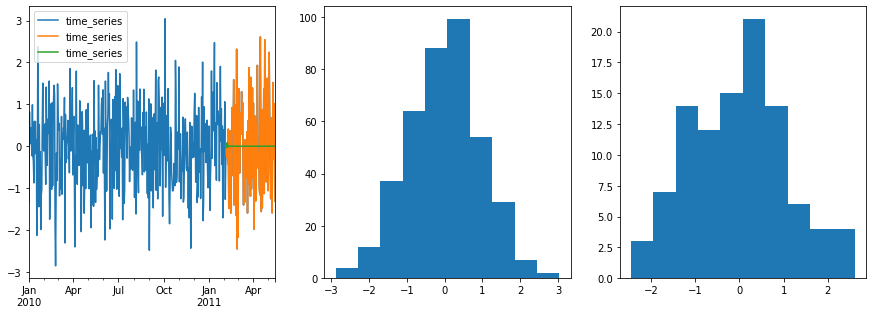

In [7]:
def run_giotto_arima(df, test_size, order, method='css-mle', plot=True):
    model = ARIMA(horizon=test_size, order=order, method=method)
    df_train = df
    df_test = df.iloc[-test_size:]
    model.fit(df_train)
    pred_g = model.predict(df_test.iloc[[0]])
    y_pred = pd.DataFrame(pred_g.values[0], index=df_test.index, columns=['time_series'])
    phi = model.model.phi_
    theta = model.model.theta_
    mu = model.model.mu_
    train_errors = model.model.errors_
    print(f'Giotto results {method}:')
    print(f'Fitted parameters: mu={mu:.2f}, p={phi}, q={theta}')
    print(f'AR roots abs:{np.abs(np.roots(np.r_[-phi[::-1], 1.0]))}')
    print(f'MA roots abs:{np.abs(np.roots(np.r_[theta[::-1], 1.0]))}')
    print(f'Train error mean: {train_errors.mean():.2f}, std: {train_errors.std():.2f}')
    print(f'LL: {model.model.model.ml:.2f}')
    print(f'RMSE: {mean_squared_error(y_pred, df_test.values):.2f}\n')
#     print(normaltest(train_errors))
    if plot:
        test_errors = df_test -  y_pred
        train_test_plot(df_train, df_test, y_pred, train_errors, test_errors.values)
    return mu, phi, theta
    
mu, phi, theta = run_giotto_arima(df_white, 100, (4, 0, 0), 'css')

Statsmodels results css:
Fitted parameters: mu=-0.00, p=[-0.07 -0.02 -0.04 -0.01], q=[]
AR roots abs:[2.63 2.63 3.88 3.88]
MA roots abs:[]
Train error mean: -0.00, std: 0.96
LL: 544.50
RMSE: 1.20



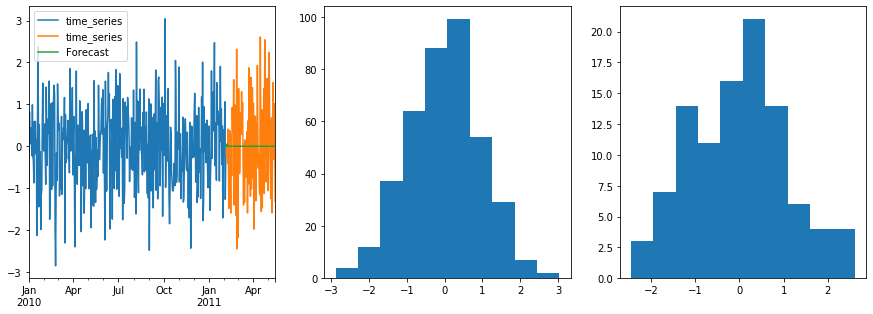

In [8]:
def run_sm(df, test_size, order, method='css-mle', plot=True):
    df_train = df.iloc[:-test_size]
    df_test = df.iloc[-test_size:]
    m2 = ARIMA_sm(df_train, order)
    f = m2.fit(method=method)
    y2, _, _ = f.forecast(test_size)
    y_pred = pd.DataFrame(y2, index=df_test.index, columns=['Forecast'])
    print(f'Statsmodels results {method}:')
    print(f'Fitted parameters: mu={f.params.const:.2f}, p={f.arparams}, q={f.maparams}')
    print(f'AR roots abs:{np.abs(f.arroots)}')
    print(f'MA roots abs:{np.abs(f.maroots)}')
    train_errors = m2.geterrors(f.params)
    print(f'Train error mean: {train_errors.mean():.2f}, std: {train_errors.std():.2f}')
    print(f'LL: {-f.llf:.2f}')
    print(f'RMSE: {mean_squared_error(y2, df_test.values):.2f}\n')
#     print(normaltest(train_errors))
    if plot:
        test_errors = df_test.values.flatten() -  y2
        train_test_plot(df_train, df_test, y_pred, train_errors, test_errors)
    return f, m2

f = run_sm(df_white, 100, (4, 0, 0), 'css')

## Simple AR check

In [12]:
df = df_white
run_giotto_ar(df, 100, 2)
run_sm(df, 100, (2, 0, 0), 'css', plot=False);
run_sm(df, 100, (2, 0, 0), 'mle', plot=False);
run_giotto_arima(df, 100, (2, 0, 0), 'css', plot=False);
run_giotto_arima(df, 100, (2, 0, 0), 'mle', plot=False);

Basic AR results results:
Fitted parameters: mu=0.01, p=[-0.03 -0.06]
RMSE: 0.90

Statsmodels results css:
Fitted parameters: mu=0.01, p=[-0.03 -0.06], q=[]
AR roots abs:[3.93 3.93]
MA roots abs:[]
Train error mean: 0.00, std: 1.02
RMSE: 0.89

Statsmodels results mle:
Fitted parameters: mu=0.02, p=[-0.02 -0.07], q=[]
AR roots abs:[3.92 3.92]
MA roots abs:[]
Train error mean: 0.00, std: 1.03
RMSE: 0.89

Giotto results css:
Fitted parameters: mu=0.01, p=[-0.03 -0.06], q=[]
AR roots abs:[3.93 3.93]
MA roots abs:[]
Train error mean: 0.00, std: 1.02
RMSE: 0.89



../gtime/stat_tools/tools.py:44: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=0.02, p=[-0.02 -0.07], q=[]
AR roots abs:[3.92 3.92]
MA roots abs:[]
Train error mean: -0.00, std: 1.03
RMSE: 0.89



In [13]:
df = df_real
run_giotto_ar(df, 100, 2)
run_sm(df, 100, (2, 0, 0), 'css', plot=False);
run_sm(df, 100, (2, 0, 0), 'mle', plot=False);
run_giotto_arima(df, 100, (2, 0, 0), 'css', plot=False);
run_giotto_arima(df, 100, (2, 0, 0), 'mle', plot=False);

Basic AR results results:
Fitted parameters: mu=3.58, p=[0.98 0.02]
RMSE: 44772.60

Statsmodels results css:
Fitted parameters: mu=3261.40, p=[0.98 0.02], q=[]
AR roots abs:[ 1.   49.74]
MA roots abs:[]
Train error mean: -0.02, std: 20.81
RMSE: 52639.91

Statsmodels results mle:
Fitted parameters: mu=2494.44, p=[0.98 0.02], q=[]
AR roots abs:[ 1.   53.84]
MA roots abs:[]
Train error mean: 0.37, std: 23.82
RMSE: 67607.63

Giotto results css:
Fitted parameters: mu=3147.93, p=[0.98 0.02], q=[]
AR roots abs:[50.01  1.  ]
MA roots abs:[]
Train error mean: -0.01, std: 20.81
RMSE: 53481.82



../gtime/stat_tools/tools.py:44: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=2442.22, p=[0.98 0.02], q=[]
AR roots abs:[46.71  1.  ]
MA roots abs:[]
Train error mean: 0.79, std: 20.80
RMSE: 54647.72



## Simple ARI check

In [11]:
df = df_white
run_sm(df, 100, (2, 1, 0), 'css', plot=False);
run_sm(df, 100, (2, 1, 0), 'mle', plot=False);
run_giotto_arima(df, 100, (2, 1, 0), 'css', plot=False);
run_giotto_arima(df, 100, (2, 1, 0), 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.00, p=[-0.69 -0.34], q=[]
AR roots abs:[1.73 1.73]
MA roots abs:[]
Train error mean: 0.00, std: 1.15
LL: 619.73
RMSE: 1.30

Statsmodels results mle:
Fitted parameters: mu=0.00, p=[-0.69 -0.33], q=[]
AR roots abs:[1.73 1.73]
MA roots abs:[]
Train error mean: -0.00, std: 1.15
LL: 622.19
RMSE: 1.31

Giotto results css:
Fitted parameters: mu=-0.00, p=[-0.69 -0.34], q=[]
AR roots abs:[1.73 1.73]
MA roots abs:[]
Train error mean: -0.00, std: 1.15
LL: 618.15
RMSE: 1.44

Giotto results mle:
Fitted parameters: mu=0.00, p=[-0.69 -0.33], q=[]
AR roots abs:[1.73 1.73]
MA roots abs:[]
Train error mean: 0.00, std: 1.15
LL: 621.13
RMSE: 1.52



In [12]:
df = df_real
run_sm(df, 100, (2, 1, 0), 'css', plot=False);
run_sm(df, 100, (2, 1, 0), 'mle', plot=False);
run_giotto_arima(df, 100, (2, 1, 0), 'css', plot=False);
run_giotto_arima(df, 100, (2, 1, 0), 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.77, p=[-0.02 -0.06], q=[]
AR roots abs:[4.23 4.23]
MA roots abs:[]
Train error mean: 0.00, std: 20.78
LL: 5147.77
RMSE: 46983.52

Statsmodels results mle:
Fitted parameters: mu=0.77, p=[-0.02 -0.06], q=[]
AR roots abs:[4.23 4.23]
MA roots abs:[]
Train error mean: 0.00, std: 20.77
LL: 5156.18
RMSE: 46931.59

Giotto results css:
Fitted parameters: mu=0.77, p=[-0.02 -0.06], q=[]
AR roots abs:[4.22 4.22]
MA roots abs:[]
Train error mean: 0.00, std: 20.79
LL: 5143.79
RMSE: 45117.28



../gtime/stat_tools/tools.py:44: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=0.78, p=[-0.02 -0.06], q=[]
AR roots abs:[4.23 4.23]
MA roots abs:[]
Train error mean: -0.01, std: 20.77
LL: 5152.09
RMSE: 45023.85



In [14]:
df = df_arima
run_sm(df, 100, (1, 1, 0), 'css', plot=False);
run_sm(df, 100, (1, 1, 0), 'mle', plot=False);
run_giotto_arima(df, 100, (1, 1, 0), 'css', plot=False);
run_giotto_arima(df, 100, (1, 1, 0), 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.06, p=[-0.34], q=[]
AR roots abs:[2.9]
MA roots abs:[]
Train error mean: 0.00, std: 0.71
LL: 428.85
RMSE: 47.45

Statsmodels results mle:
Fitted parameters: mu=0.06, p=[-0.34], q=[]
AR roots abs:[2.91]
MA roots abs:[]
Train error mean: 0.00, std: 0.71
LL: 429.62
RMSE: 47.83

Giotto results css:
Fitted parameters: mu=0.06, p=[-0.34], q=[]
AR roots abs:[2.9]
MA roots abs:[]
Train error mean: 0.00, std: 0.71
LL: 428.24
RMSE: 57.48

Giotto results mle:
Fitted parameters: mu=0.06, p=[-0.34], q=[]
AR roots abs:[2.91]
MA roots abs:[]
Train error mean: -0.00, std: 0.71
LL: 428.88
RMSE: 57.53



## Full ARIMA check

In [15]:
df = df_white
run_sm(df, 100, (2, 1, 3), 'css', plot=False);
run_sm(df, 100, (2, 1, 3), 'mle', plot=False);
run_giotto_arima(df, 100, (2, 1, 3), 'css', plot=False);
run_giotto_arima(df, 100, (2, 1, 3), 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.00, p=[-1.13 -0.93], q=[ 0.16 -0.14 -0.96]
AR roots abs:[1.04 1.04]
MA roots abs:[1.01 1.01 1.02]
Train error mean: 0.03, std: 0.98
LL: 555.94
RMSE: 1.04



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
../gtime/stat_tools/mle_estimate.py:109: RuntimeWarning: invalid value encountered in double_scalars
  loglikelihood = -nobs / 2. * (np.log(2 * np.pi * sigma2)) - ssr / (2. * sigma2)


Statsmodels results mle:
Fitted parameters: mu=0.00, p=[-1.13 -0.95], q=[ 0.15 -0.15 -1.  ]
AR roots abs:[1.03 1.03]
MA roots abs:[1. 1. 1.]
Train error mean: 0.03, std: 0.97
LL: 555.52
RMSE: 1.05

Giotto results css:
Fitted parameters: mu=-0.00, p=[-0.86 -0.46], q=[-0.16 -0.37 -0.48]
AR roots abs:[1.47 1.47]
MA roots abs:[1.45 1.45 1.  ]
Train error mean: 0.00, std: 0.98
LL: 553.32
RMSE: 1.90



../gtime/stat_tools/tools.py:44: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=0.00, p=[0.   0.83], q=[-1.1  -0.77  0.87]
AR roots abs:[1.1  1.09]
MA roots abs:[1.13 1.01 1.01]
Train error mean: 0.02, std: 0.97
LL: 553.24
RMSE: 464.99



In [17]:
df = df_real
run_sm(df, 100, (4, 1, 3), 'css', plot=False);
run_sm(df, 100, (4, 1, 3), 'mle', plot=False);
run_giotto_arima(df, 100, (4, 1, 3), 'css', plot=False);
run_giotto_arima(df, 100, (4, 1, 3), 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.80, p=[ 0.29  0.41 -0.46 -0.04], q=[-0.31 -0.45  0.5 ]
AR roots abs:[ 1.22  1.29  1.29 12.28]
MA roots abs:[1.15 1.31 1.31]
Train error mean: -0.00, std: 20.75
LL: 5136.88
RMSE: 46905.24

Statsmodels results mle:
Fitted parameters: mu=0.81, p=[ 0.38 -0.2   0.77 -0.02], q=[-0.4   0.15 -0.72]
AR roots abs:[ 1.03  1.13  1.13 38.81]
MA roots abs:[1.01 1.17 1.17]
Train error mean: -0.10, std: 20.68
LL: 5150.93
RMSE: 49264.60



../gtime/stat_tools/mle_estimate.py:109: RuntimeWarning: invalid value encountered in double_scalars
  loglikelihood = -nobs / 2. * (np.log(2 * np.pi * sigma2)) - ssr / (2. * sigma2)


Giotto results css:
Fitted parameters: mu=0.82, p=[-0.29  0.52 -0.01  0.  ], q=[ 0.27 -0.58  0.01]
AR roots abs:[17.71 17.71  1.71  1.13]
MA roots abs:[42.65  1.6   1.09]
Train error mean: 0.01, std: 20.74
LL: 5131.77
RMSE: 44562.98

Giotto results mle:
Fitted parameters: mu=0.78, p=[0.69 0.43 0.15 0.54], q=[0.09 0.49 0.57]
AR roots abs:[1.29 1.38 1.38 0.75]
MA roots abs:[1.52 1.08 1.08]
Train error mean: 2.99, std: 136.20
LL: 2042295.57
RMSE: 1863387196268472958976.00



In [16]:
df = df_arima
run_sm(df, 100, (2, 1, 3), 'css', plot=False);
run_sm(df, 100, (2, 1, 3), 'mle', plot=False);
run_giotto_arima(df, 100, (2, 1, 3), 'css', plot=False);
run_giotto_arima(df, 100, (2, 1, 3), 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.06, p=[-0.82  0.11], q=[ 0.5  -0.23  0.14]
AR roots abs:[1.06 8.49]
MA roots abs:[1.09 2.55 2.55]
Train error mean: -0.00, std: 0.71
LL: 426.91
RMSE: 46.56

Statsmodels results mle:
Fitted parameters: mu=0.06, p=[-0.87  0.07], q=[ 0.54 -0.2   0.13]
AR roots abs:[ 1.06 14.07]
MA roots abs:[1.09 2.65 2.65]
Train error mean: 0.00, std: 0.71
LL: 428.26
RMSE: 46.89



../gtime/stat_tools/mle_estimate.py:109: RuntimeWarning: invalid value encountered in double_scalars
  loglikelihood = -nobs / 2. * (np.log(2 * np.pi * sigma2)) - ssr / (2. * sigma2)


Giotto results css:
Fitted parameters: mu=0.06, p=[-0.87  0.07], q=[ 0.54 -0.2   0.13]
AR roots abs:[14.1   1.06]
MA roots abs:[2.65 2.65 1.09]
Train error mean: 0.00, std: 0.71
LL: 426.28
RMSE: 51.69



../gtime/stat_tools/tools.py:44: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=-11.33, p=[0.08 0.92], q=[-0.26 -0.73 -0.01]
AR roots abs:[1.09 1.  ]
MA roots abs:[55.52  1.38  1.  ]
Train error mean: -0.00, std: 0.74
LL: 449.22
RMSE: 6187.89



## Performance tests

In [325]:
%%cython -a
from scipy.linalg.cython_blas cimport dsymm, dgemm, dgemv, daxpy, dsyr, dcopy
from scipy.linalg.cython_lapack cimport dpotrf
from numpy cimport NPY_DOUBLE, npy_intp, PyArray_ZEROS, import_array, float64_t, ndarray
from numpy import zeros_like
from libc.math cimport log, M_PI

import_array()


cdef double llf_cp(double nu, double F):
    return -0.5 * (log(2 * M_PI * abs(F)) + nu * nu / F)


cdef void add_mat(double[::1, :] a, double[::1, :] b, int r, int c):
    
    cdef int i = 0
    cdef int j = 0
    
    for i in range(r):
        for j in range(c):
            a[i, j] = a[i, j] + b[i, j]
    

cdef void mat_square_c(double[::1, :] x, double[::1, :] q, int n):
    cdef int ldt = x.strides[1] // sizeof(float64_t)
    cdef double one = 1.0
    cdef double zero = 0.0
    cdef npy_intp r2shape[2] 
    r2shape[0] = <npy_intp> n
    r2shape[1] = <npy_intp> n
    cdef double[::1, :] res = PyArray_ZEROS(2, r2shape, NPY_DOUBLE, 1)
    dsymm('R', 'U', &n, &n, &one, &q[0, 0], &ldt, &x[0, 0], &ldt, &zero, &res[0, 0], &ldt)
    dgemm("N", "T", &n, &n, &n, &one, &res[0, 0], &ldt, &x[0, 0], &ldt, &zero, &x[0, 0], &ldt)


def roll(double[::1] x, double[::1] a, double[::1, :] p, double[::1] eps,
            double mu, double F, double nu,
            double[::1, :] rqr, double[::1, :] K,
           int r, int n):
    
    cdef int lda = a.strides[0] // sizeof(float64_t)
    cdef int ldk = K.strides[1] // sizeof(float64_t)
    cdef int ldp = p.strides[1] // sizeof(float64_t)
    cdef double one = 1.0
    cdef double zero = 0.0
    cdef double F_c = F
    cdef float64_t F_inv
    cdef float64_t nf
    cdef float64_t loglikelihood = 0.0
    cdef bint converged = False
    cdef int i = 0
    cdef double[::1] a_t = zeros_like(a, order='F')
    
    # for i, x in enumerate(X[1:]):
    for i in range(n-1):
         
        if F_c == rqr[0, 0]:
            converged = True
        
        F_inv = -1.0 / F_c
        nf = -nu * F_inv

        if converged:
            # a = a + p[:, 0] * nu / F
            # a = np.matmul(K, a)
            daxpy(&r, &nf, &p[0, 0], &ldp, &a[0], &lda)
            dgemv('N', &r, &r, &one, &K[0, 0], &ldk, &a[0], &lda, &zero, &a_t[0], &lda)
            dcopy(&r, &a_t[0], &lda, &a[0], &lda)
            
        else:
            # a = a + p[:, 0] * nu / F
            # p = p - np.dot(gain, pz.T)

            daxpy(&r, &nf, &p[0, 0], &ldp, &a[0], &lda)
            dsyr('L', &r, &F_inv, &p[0, 0], &ldp, &p[0, 0], &r)

            # a = np.matmul(K, a)
            # p = mat_square(p, K) + rqr
            # F = p[0, 0]

            dgemv('N', &r, &r, &one, &K[0, 0], &ldk, &a[0], &lda, &zero, &a_t[0], &lda)
            dcopy(&r, &a_t[0], &lda, &a[0], &lda)
            mat_square_c(p, K, r)
            add_mat(p, rqr, r, r)
            F_c = p[0, 0]

        nu = x[i+1] - a[0] - mu
        eps[i+1] = nu
        ll_last = llf_cp(nu, F_c)
        loglikelihood = loglikelihood + ll_last
    
    return loglikelihood, eps
    

In [283]:
# previous "fast" version
def alt_likelihood_old(X, mu, sigma, phi, theta, errors=False):

    m = len(phi)
    R = np.array([np.r_[1.0, theta[:-1]]]).T
    K = np.concatenate((phi[:-1].reshape((-1, 1)), np.identity(m - 1)), axis=1)
    K = np.concatenate((K, np.concatenate((phi[-1:], np.zeros(m - 1))).reshape(1, -1)))
    Q = np.array([[sigma ** 2]])
    Z = np.zeros((1, m))
    Z[0, 0] = 1.0
    eps = np.zeros(len(X))
    vec_RR = np.matmul(R, R.T).ravel()
    vec_K = np.linalg.inv(np.identity(m ** 2) - np.kron(K, K))
    p = sigma ** 2 * np.matmul(vec_K, vec_RR).reshape((m, m))
    a = np.zeros((m, 1))
    x_hat = a[0] + mu
    nu = float(X[0] - x_hat)
    F = p[0, 0]

    p_hat = p
    a_hat = a
    
    LL_last = -0.5 * (np.log(2 * np.pi * np.abs(F)) + nu * nu / F)
    loglikelihood = LL_last
    eps[0] = nu
    rqr = mat_square(Q, R)
#     print(K)
    for i, x in enumerate(X[1:]):
        
#         print('A0', '\t'.join(map(str, a_hat.flatten())))
        pz = p_hat[:, [0]]
        gain = pz / F
#         print('\t'.join(map(str, (gain * nu).flatten())))
        a = a_hat + gain * nu
        p = p_hat - np.dot(gain, pz.T)
#         print('A1', '\t'.join(map(str, a.flatten())))
        
        a_hat = np.matmul(K, a)
        p_hat = mat_square(p, K) + rqr
        x_hat = a_hat[0] + mu
        F = p_hat[0, 0]
#         print('A2', '\t'.join(map(str, a_hat.flatten())))
#         print('\t'.join(map(str, a.flatten())))

        nu = float(x - x_hat)
        eps[i] = nu
        LL_last = -0.5 * (np.log(2 * np.pi * np.abs(F)) + nu * nu / F)
        loglikelihood += LL_last
    return loglikelihood, eps

In [230]:
# Statsmodels wrapper
from statsmodels.tsa.kalmanf import kalman_loglike
def alt_likelihood_sm(X, mu, sigma, phi, theta, errors=False):

    m = len(phi)
    R = np.array([np.r_[1.0, theta[:-1]]]).T
    K = np.concatenate((phi[:-1].reshape((-1, 1)), np.identity(m - 1)), axis=1)
    K = np.concatenate((K, np.concatenate((phi[-1:], np.zeros(m - 1))).reshape(1, -1)))
    Q = np.array([[sigma ** 2]])
    Z = np.zeros((1, m))
    Z[0, 0] = 1.0
    eps = np.zeros(len(X))
    vec_RR = np.matmul(R, R.T).ravel()
    vec_K = np.linalg.inv(np.identity(m ** 2) - np.kron(K, K))
    p = sigma ** 2 * np.matmul(vec_K, vec_RR).reshape((m, m))
    a = np.zeros(m)
    x_hat = a[0] + mu
    nu = float(X[0] - x_hat)
    F = p[0, 0]

    p = np.array(p, order='F')
    K = np.array(K, order='F')
    
    LL_last = -0.5 * (np.log(2 * np.pi * np.abs(F)) + nu * nu / F)
    loglikelihood = LL_last
    eps[0] = nu
    rqr = mat_square(Q, R)
    rqr = np.array(rqr, order='F')
    r = p.shape[0]
    n = len(X)
    eps, fs, ll = kalman_loglike.kalman_filter_double(X, 1, len(phi), len(theta), r, n, Z, R, K)
    llh, s = kalman_loglike.kalman_loglike_double(X, 1, len(phi), len(theta), r, n, Z, R, K)
    loglikelihood += ll
    return ll, eps, fs, llh, s

In [87]:
# Cython engine wrapper
def alt_likelihood(X, mu, sigma, phi, theta, errors=False):

    m = len(phi)
    R = np.array([np.r_[1.0, theta[:-1]]]).T
    K = np.concatenate((phi[:-1].reshape((-1, 1)), np.identity(m - 1)), axis=1)
    K = np.concatenate((K, np.concatenate((phi[-1:], np.zeros(m - 1))).reshape(1, -1)))
    Q = np.array([[sigma ** 2]])
    Z = np.zeros((1, m))
    Z[0, 0] = 1.0
    eps = np.zeros(len(X))
    vec_RR = np.matmul(R, R.T).ravel()
    vec_K = np.linalg.inv(np.identity(m ** 2) - np.kron(K, K))
    p = sigma ** 2 * np.matmul(vec_K, vec_RR).reshape((m, m))
    a = np.zeros(m)
    x_hat = a[0] + mu
    nu = float(X[0] - x_hat)
    F = p[0, 0]

    p = np.array(p, order='F')
    K = np.array(K, order='F')
    
    LL_last = -0.5 * (np.log(2 * np.pi * np.abs(F)) + nu * nu / F)
    loglikelihood = LL_last
    eps[0] = nu
    rqr = mat_square(Q, R)
    rqr = np.array(rqr, order='F')
    r = p.shape[0]
    n = len(X)
    ll, eps = roll(X, a, p, eps, mu, F, nu, rqr, K, r, n)
    return loglikelihood + ll, eps

In [234]:
# input data
x = df_real.values.flatten()
x -= x.mean()
phi = np.array([0.3, 0.2])
theta = np.array([0.1, 0.0])

In [239]:
pd.DataFrame(eps.flatten()).to_clipboard()

In [306]:
pd.DataFrame(np.array(eps)).to_clipboard()

In [335]:
ll , eps_sm, f, ll_sm, s = alt_likelihood_sm(x, 0.0, 20.0, phi, theta)

In [336]:
ll_g, eps_g = alt_likelihood(x, 0.0, np.sqrt(s), phi, theta)

In [342]:
ll_g - ll_sm

-0.004798894884515903

In [343]:
eps_sm - eps_g

array([[ 0.00e+00, -1.77e+02, -2.33e+02, ..., -5.85e+02, -2.08e+02,
        -4.40e+02],
       [ 1.77e+02,  5.68e-14, -5.60e+01, ..., -4.08e+02, -3.04e+01,
        -2.63e+02],
       [ 2.33e+02,  5.55e+01, -5.31e-01, ..., -3.53e+02,  2.50e+01,
        -2.07e+02],
       ...,
       [ 5.85e+02,  4.08e+02,  3.52e+02, ...,  2.84e-14,  3.78e+02,
         1.46e+02],
       [ 2.08e+02,  3.04e+01, -2.56e+01, ..., -3.78e+02,  0.00e+00,
        -2.32e+02],
       [ 4.40e+02,  2.63e+02,  2.07e+02, ..., -1.46e+02,  2.32e+02,
         1.42e-14]])

In [344]:
%timeit alt_likelihood_sm(x, 0.0, np.sqrt(s), phi, theta)

912 µs ± 147 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [345]:
%timeit alt_likelihood_old(x, 0.0, np.sqrt(s), phi, theta)

42.3 ms ± 4.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [346]:
%timeit alt_likelihood(x, 0.0, np.sqrt(s), phi, theta)

366 µs ± 92.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Compiling

In [112]:
from setuptools import setup
from Cython.Build import cythonize

setup(
    name='Loglikelihood function',
    ext_modules=cythonize("loglike.pyx"),
    zip_safe=False,
)

Compiling loglike.pyx because it changed.
[1/1] Cythonizing loglike.pyx


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /Users/semyonburyachenko/Documents/Upwork/Giotto/giotto-time/examples/loglike.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


SystemExit: usage: ipykernel_launcher.py [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
   or: ipykernel_launcher.py --help [cmd1 cmd2 ...]
   or: ipykernel_launcher.py --help-commands
   or: ipykernel_launcher.py cmd --help

error: option -f not recognized

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [9]:
from loglike import llf_c as llf_so

In [8]:
! python3 setup.py build_ext --inplace

running build_ext
copying build/lib.macosx-10.9-x86_64-3.7/loglike.cpython-37m-darwin.so -> 


In [165]:
%%cython -a
from libc.math cimport log, M_PI

def llf_c(double nu, double F):
    return llf_cp(nu,  F)

cdef double llf_cp(double nu, double F):
    return -0.5 * (log(2 * M_PI * abs(F)) + nu * nu / F)
